# Perfect 2D crystal
This notebook computes the scattering from a perfect square crystal (i.e. the 2D Laue function) by direct summation of the waves scattered by each unit-cell:
$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{n=0}^{N-1} \exp \left [ 2 \pi i \left ( H n + K m \right ) \right ] \right| ^2$$

First we load the external libraries.

In [1]:
import os
import math
import cmath
import numpy as np
import numba as nb
import numexpr as ne
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
n_cpu = os.cpu_count()

Then we define the size of the crystal (N) and the HK reflection to be computed. A complete reciprocal space unit-cell is rendered with a resolution defined by the sampling rate.

In [2]:
H = 0 #Miller index of reflection
K = 4 #Miller index of reflection
N = 100 #Number of units cells per direction
oversampling = 6 #Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
#Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

## Pure python implementation

In [3]:
def Laue_python(n, m, h, k):
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0.0
            for i_n in n:#loop and sum over unit-cells
                for i_m in m:
                    tmp += cmath.exp(2j*np.pi*(v_h*i_n + v_k*i_m))
            result[i_h][i_k] = abs(tmp)**2
    return np.array(result)

#Compute
%time ref_intensity = Laue_python(n, m, h, k)

CPU times: user 35min 19s, sys: 1.96 s, total: 35min 21s
Wall time: 35min 21s


<IPython.core.display.Javascript object>


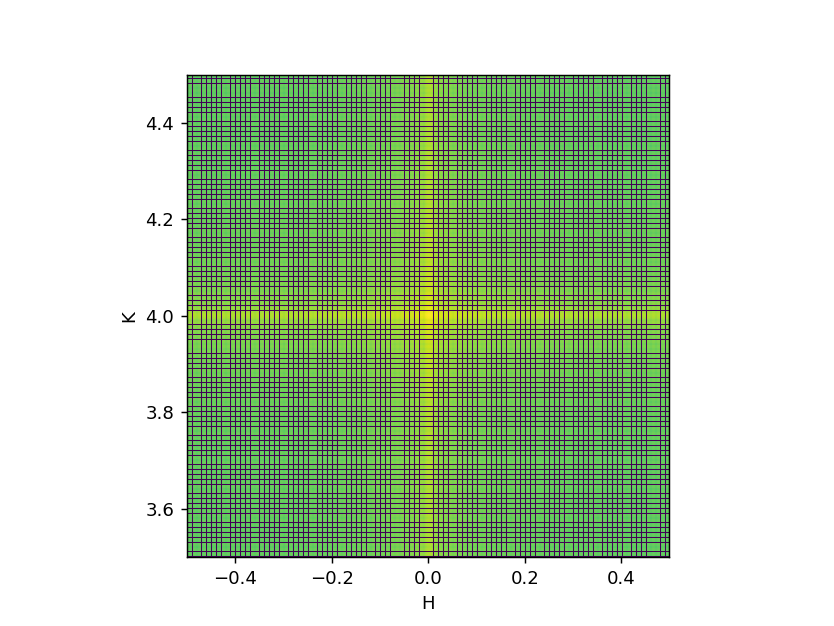

In [4]:
%matplotlib notebook
plt.figure(1)
plt.imshow(ref_intensity.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
plt.xlabel('H')
plt.ylabel('K')
plt.show()

## Pure Numpy implementation

In [5]:
def Laue_numpy(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    #h,k,n,m = np.meshgrid(h,k,n,m)
    return np.abs(np.exp(2j*np.pi*(h*n + k*m)).sum(axis=(2,3)))**2

#Compute and check error
%timeit Laue_numpy(n, m, h, k)
intensity = Laue_numpy(n, m, h, k)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 4min per loop
Error: 1.2069940567e-14


## Numpy + for loop
This is a variant of the above version where two loops are run over h/k in order to limit memory bandwidth issues

In [6]:
def Laue_numpy_hybrid(n, m, h, k):
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    n=n[:,np.newaxis]
    m=m[np.newaxis,:]
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = np.exp(2j*np.pi*(v_h*n + v_k*m)).sum()
            result[i_h][i_k] = tmp.real**2 + tmp.imag**2
    return np.array(result)

#Compute and check error
%timeit Laue_numpy_hybrid(n, m, h, k)
intensity = Laue_numpy_hybrid(n, m, h, k)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 2min 58s per loop
Error: 1.2218952179e-14


## NumExpr implementation

In [7]:
def Laue_numexpr(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    j2pi = np.pi*2j
    ne.set_num_threads(1) # By default Numexpr uses min(n_cpu, 8) threads
    tmp = ne.evaluate("exp(j2pi*(h*n + k*m))").reshape((h.size, k.size, -1))
    tmp = ne.evaluate("sum(tmp,2)")
    return np.abs(tmp)**2
#Compute and check error
%timeit Laue_numexpr(n, m, h, k)
intensity = Laue_numexpr(n, m, h, k)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 3min 24s per loop
Error: 0.0


## NumExpr (multi-threaded) implementation

In [8]:
def Laue_numexpr_parallel(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    j2pi = np.pi*2j
    ne.set_num_threads(n_cpu)
    tmp = ne.evaluate("exp(j2pi*(h*n + k*m))").reshape((h.size, k.size, -1))
    tmp = ne.evaluate("sum(tmp,2)")
    return np.abs(tmp)**2
#Compute and check error
%timeit Laue_numexpr_parallel(n, m, h, k)
intensity = Laue_numexpr_parallel(n, m, h, k)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 15.6 s per loop
Error: 0.0


## Numba (single thread) implementation

In [9]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:]),nopython=True)
def Laue_numba(n, m, h, k):
    result = np.zeros((len(h), len(k)), dtype=nb.float64)
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0j # the result of the sum is stored in a temporary complex variable
            for i_n in n: #loop and sum over unit-cells
                for i_m in m:
                    tmp += cmath.exp(2j*cmath.pi*(v_h*i_n +v_k*i_m))
            result[i_h, i_k] = abs(tmp)**2
    return result

#Compute and check error
%timeit Laue_numba(n, m, h, k)
intensity = Laue_numba(n, m, h, k)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 2min 48s per loop
Error: 0.0


## Numba (multi-threaded / parallel) implementation

In [10]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:]), 
        nopython=True, parallel=True, fastmath=True)
def Laue_numba_parallel(n,m,h,k):
    result = np.zeros(len(h)*len(k), dtype=nb.float64)
    for i in nb.prange(len(h)*len(k)): #loop over the reciprocal space coordinates
        tmp = 0j
        for i_n in n:
            for i_m in m:#loop and sum over unit-cells
                tmp +=  cmath.exp(2j*cmath.pi*(h[i//len(h)]*i_n + k[i%len(h)]*i_m)) #cmath library works better with numba than numpy math
        result[i] = abs(tmp)**2
    return result.reshape(len(h),len(k))
#Compute and check error
%timeit Laue_numba_parallel(n, m, h, k)
intensity = Laue_numba_parallel(n, m, h, k)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 5.25 s per loop
Error: 0.0


## Pythran (single thread) implementation

In [11]:
%load_ext pythran.magic

In [12]:
%%pythran -fopenmp

#pythran export Laue_pythran(int[] or float[], int[] or float[], float[], float[])
import numpy as np

def Laue_pythran(n, m, h, k):
    result = np.zeros((len(h), len(k)), dtype=np.float64)
#    "omp parallel for"
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0j
            #loop and sum over unit-cells
            for i_n in n:
                for i_m in m:
                    tmp += np.exp(2j*np.pi*(v_h*i_n + v_k*i_m))
            result[i_h, i_k] = abs(tmp)**2
    return result

In [13]:
#Compute and check error
%timeit Laue_pythran(n, m, h, k)
intensity = Laue_pythran(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max()/ref_intensity.max())

1 loop, best of 3: 2min 29s per loop
Error: 2.98023223877e-16


## Pythran (multi-threaded) implementation

In [14]:
%%pythran -fopenmp
#pythran export Laue_pythran_parallel(int[] or float[], int[] or float[], float[], float[])
import numpy as np

def Laue_pythran_parallel(n, m, h, k):
    result = np.zeros((len(h), len(k)), dtype=np.float64)
    "omp parallel for"
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0j
            #loop and sum over unit-cells
            for i_n in n:
                for i_m in m:
                    tmp += np.exp(2j*np.pi*(v_h*i_n + v_k*i_m))
            result[i_h, i_k] = abs(tmp)**2
    return result

In [15]:
#Compute and check error
%timeit Laue_pythran_parallel(n, m, h, k)
intensity = Laue_pythran_parallel(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max()/ref_intensity.max())

1 loop, best of 3: 4.72 s per loop
Error: 2.98023223877e-16


## Cython (single thread) implementation

In [16]:
%load_ext Cython

In [17]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

cdef extern from "complex.h" nogil:
    double complex cexp(double complex)
    double cabs(double complex)
    
@cython.wraparound(False)
@cython.boundscheck(False)
def Laue_cython(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k):
    cdef:
        double[:, ::1] result
        double r_part, i_part
        double complex tmp, two_j_pi
        int i_h, i_k, i_m, i_n, size_h, size_k, size_n, size_m
        
    two_j_pi = np.pi*2j
    size_h = h.size
    size_k = k.size
    size_n = n.size
    size_m = m.size
    result = np.zeros((size_h, size_k))
    for i_h in range(size_h):
    #for i_h in prange(size_h, nogil=True, num_threads=80): #loop over the reciprocal space coordinates
        for i_k in range(size_k):
            tmp = 0
            for i_n in range(size_n):
                for i_m in range(size_m):#loop and sum over unit-cells
                    tmp = tmp + cexp(two_j_pi*(h[i_h]*n[i_n] +k[i_k]*m[i_m]))
            result[i_h, i_k] += cabs(tmp)**2
    return result

In [18]:
#Compute and check error
%timeit Laue_cython(n, m, h, k)
intensity = Laue_cython(n, m, h, k)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 2min 41s per loop
Error: 0.0


## Cython (multi-threaded) implementation

In [19]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

cdef extern from "complex.h" nogil:
    double complex cexp(double complex)
    double cabs(double complex)
    
@cython.wraparound(False)
@cython.boundscheck(False)
def Laue_cython_parallel(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k):
    cdef:
        double[:, ::1] result
        double r_part, i_part
        double complex tmp, two_j_pi
        int i_h, i_k, i_m, i_n, size_h, size_k, size_n, size_m
        
    two_j_pi = np.pi*2j
    size_h = h.size
    size_k = k.size
    size_n = n.size
    size_m = m.size
    result = np.zeros((size_h, size_k))
    #for i_h in range(size_h):
    for i_h in prange(size_h, nogil=True): #loop over the reciprocal space coordinates
        for i_k in range(size_k):
            tmp = 0
            for i_n in range(size_n):
                for i_m in range(size_m):#loop and sum over unit-cells
                    tmp = tmp + cexp(two_j_pi*(h[i_h]*n[i_n] +k[i_k]*m[i_m]))
            result[i_h, i_k] += cabs(tmp)**2
    return result

In [20]:
#Compute and check error
%timeit Laue_cython_parallel(n, m, h, k)
intensity = Laue_cython_parallel(n, m, h, k)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

1 loop, best of 3: 4.98 s per loop
Error: 0.0


## Fast Fourier Transformation

In [21]:
def Laue_fft(N):
    support = np.zeros([oversampling*N,oversampling*N]) #create a support function padded with 0s
    support[0:N, 0:N]=1 #the first N values
    return np.fft.fftshift(abs(np.fft.fft2(support))**2)
#Compute and check
%timeit Laue_fft(N)
intensity = Laue_fft(N)
print("Error:", abs(intensity-ref_intensity).max()/ref_intensity.max())

100 loops, best of 3: 17.5 ms per loop
Error: 9.12360846996e-12


# Benchmark

In [22]:
list_N = np.array([4,6,9,12,18,25,35,50,70,100])
with open("Benchmark_Square_samp6.txt", "w") as file:
    file.write("NxN, Python, Numpy, Err_np, Numpy_h, Err_nph, Numexpr, Err_ne, Numexpr_p, Err_nep,"
               "Numba, Err_nb, Numba_p, Err_nbp, Pythran, Err_pt, Pythran_p, Err_ptp, Cython, Err_ct,"
               "Cython_p, Err_ctp, FFT, Err_fft \n")
    for N in list_N:
        print("N =", N)
        n = np.arange(N)
        m = np.arange(N)
        h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
        k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))
        file.write(str(N*N)+",")
        
        print("Computing Python")
        res = %timeit -o Laue_python(n, m, h, k)
        ref_intensity = Laue_python(n, m, h, k)
        file.write(str(res.best)+",")
        
        print("Computing Numpy")
        res = %timeit -o Laue_numpy(n, m, h, k)
        rel_error = abs(Laue_numpy(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing Numpy hybrid")
        res = %timeit -o Laue_numpy_hybrid(n, m, h, k)
        rel_error = abs(Laue_numpy_hybrid(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing NumExpr")
        res = %timeit -o Laue_numexpr(n, m, h, k)
        rel_error = abs(Laue_numexpr(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing NumExpr parallel")
        res = %timeit -o Laue_numexpr_parallel(n, m, h, k)
        rel_error = abs(Laue_numexpr_parallel(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing Numba")
        res = %timeit -o Laue_numba(n, m, h, k)
        rel_error = abs(Laue_numba(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing Numba parallel")
        res = %timeit -o Laue_numba_parallel(n, m, h, k)
        rel_error = abs(Laue_numba_parallel(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing Pythran")
        res = %timeit -o Laue_pythran(n, m, h, k)
        rel_error = abs(Laue_pythran(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing Pythran Parallel")
        res = %timeit -o Laue_pythran_parallel(n, m, h, k)
        rel_error = abs(Laue_pythran_parallel(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing Cython")
        res = %timeit -o Laue_cython(n, m, h, k)
        rel_error = abs(Laue_cython(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing Cython Parallel")
        res = %timeit -o Laue_cython_parallel(n, m, h, k)
        rel_error = abs(Laue_cython_parallel(n, m, h, k) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+",")
        
        print("Computing FFT")
        res = %timeit -o Laue_fft(N)
        rel_error = abs(Laue_fft(N) - ref_intensity).max() / ref_intensity.max()
        file.write(str(res.best)+","+str(rel_error)+"\n")
print("Done.")

N = 4
Computing Python
100 loops, best of 3: 8.14 ms per loop
Computing Numpy
1000 loops, best of 3: 1.12 ms per loop
Computing Numpy hybrid
100 loops, best of 3: 6.54 ms per loop
Computing NumExpr
The slowest run took 5.44 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.08 ms per loop
Computing NumExpr parallel
100 loops, best of 3: 5.47 ms per loop
Computing Numba
1000 loops, best of 3: 782 µs per loop
Computing Numba parallel
1000 loops, best of 3: 699 µs per loop
Computing Pythran
1000 loops, best of 3: 995 µs per loop
Computing Pythran Parallel
The slowest run took 24.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 126 µs per loop
Computing Cython
1000 loops, best of 3: 1.03 ms per loop
Computing Cython Parallel
The slowest run took 53.61 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best